Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# FLAML Customized Learner

* Create your own objective functions for the estimator

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from flaml import AutoML
from flaml.data import get_output_from_log
from flaml.model import LGBMEstimator, BaseEstimator
from sklearn.metrics import r2_score
from flaml import tune

np.random.seed(10)

import flaml
print(flaml.__version__)

0.5.11


In [2]:
df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales.pkl')

# train, test split for df
train_df = df.loc[df['Year'].astype(str) < '2015']
test_df = df.loc[df['Year'].astype(str) == '2015']

y_train, y_test = train_df['Sales'], test_df['Sales']
X_train, X_test = train_df.drop(['Sales', 'Date', 'Year'], axis=1), test_df.drop(['Sales', 'Date', 'Year'], axis=1)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train.head()

(532529, 18) (161332, 18) (532529,) (161332,)


,Store,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,3,327,1,0,0,1
1,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,2,703,1,0,0,1
2,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,1,700,1,0,0,1
3,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,7,0,0,0,0,1
4,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,6,684,1,0,0,1


In [3]:
def plot_learning_curve(training_time_list,  best_error_list):
    plt.title('Learning Curve')
    plt.xlabel('Training Time (s)')
    plt.ylabel('Best Validation Loss')
    plt.scatter(training_time_list,  best_error_list)
    plt.step(training_time_list, best_error_list, where='post')
    plt.show()
    

def get_percentile(col):
    result = {'min': np.percentile(col, 0), '1%':np.percentile(col, 1),
             '5%':np.percentile(col, 5), '15%':np.percentile(col, 15),
             '25%':np.percentile(col, 25), '50%':np.percentile(col, 50), '75%':np.percentile(col, 75),
             '85%':np.percentile(col, 85), '95%':np.percentile(col, 95), '99%':np.percentile(col, 99),
              'max':np.percentile(col, 100)}
    return result

Training target distribution: {'min': 0.0, '1%': 0.0, '5%': 0.0, '15%': 0.0, '25%': 3644.0, '50%': 5702.0, '75%': 7859.0, '85%': 9280.0, '95%': 12240.0, '99%': 17116.0, 'max': 38037.0}


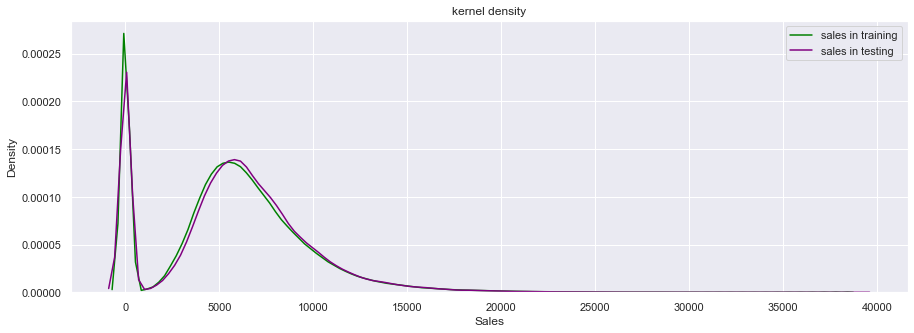

In [4]:
import seaborn as sns
sns.set(color_codes=True)

fig = plt.figure(figsize=(15,5))
sns.kdeplot(y_train, label="sales in training", color='green')
sns.kdeplot(y_test, label="sales in testing", color='purple')
plt.legend()
plt.title('kernel density')
plt.xlabel('Sales')
plt.ylabel('Density')

print(f'Training target distribution: {get_percentile(y_train)}')

## LGBM Built-in Poisson Objective Function with Sales Data

* The formula of LGBM built-in poisson loss function: https://github.com/microsoft/LightGBM/blob/7076cb8a3ac3a7b32dcf37be5593dddf27bf7f16/src/objective/regression_objective.hpp#L446
  * `max_delta_step = 0.7`
    * The value is set in its config: https://github.com/microsoft/LightGBM/blob/7076cb8a3ac3a7b32dcf37be5593dddf27bf7f16/include/LightGBM/config.h#L792
  * `grad = exp(y_pred) - y_true`
  * `hess = exp(y_pred + max_delta_step)`

Finished loading model, total used 100 iterations
Finished loading model, total used 26 iterations
Finished loading model, total used 26 iterations
Finished loading model, total used 30 iterations
Finished loading model, total used 26 iterations
Finished loading model, total used 30 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 40 iterations
Finished loading model, total used 353 iterations
Finished loading model, total used 753 iterations
Finished loading model, total used 165 iterations
Finished loading model, total used 308 iterations
Finished loading model, total used 165 iterations
Finished loading model, total used 244 iterations
Finished loading model, total used 389 iterations
Finished loading model, total used 1006 iterations
Finished loading model, total used 308 iterations
Finished loading model, total used 1208 iterations
Finished loading model, total used 1006 iterations
Finished loading model, total used 578 iterations
Fin

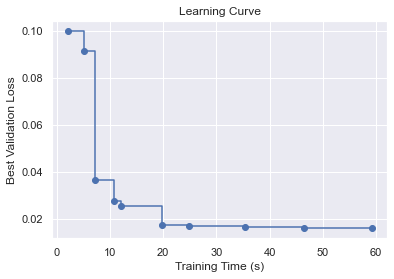

In [132]:
# poisson
class my_lgbm(LGBMEstimator):
    
    def __init__(self, categorical_feature='auto', feature_name='auto', **params):  # LGBM recognize categorical features automatically
        super().__init__( objective='poisson', **params) 
        
        if "min_child_samples" in self.params:
            self.params["min_child_samples"] = None  # set as None to remove the param from the estimator
        
    @classmethod
    def search_space(cls, data_size, **params):
        upper = min(32768, int(data_size))
        return {
            'n_estimators': {'domain': tune.lograndint(lower=40, upper=upper), 'init_value': 100, 'low_cost_init_value': 100},
            'num_leaves': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'min_child_samples': {'domain': tune.lograndint(lower=2, upper=2**7), 'init_value': 20},  # ignored param but has to appear here
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0), 'init_value': 0.1},
            'subsample': {'domain': tune.uniform(lower=0.1, upper=1.0), 'init_value': 1.0},
            'log_max_bin': {'domain': tune.lograndint(lower=3, upper=10), 'init_value': 8},
            'colsample_bytree': {'domain': tune.uniform(lower=0.01, upper=1.0), 'init_value': 1.0},
            'reg_alpha': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1 / 1024},
            'reg_lambda': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1.0},
            'max_depth': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 7, 'low_cost_init_value': 7},
            'min_data_in_leaf': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 50, 'low_cost_init_value': 50},
            'extra_trees': {'domain': True, 'init_value': True, 'low_cost_init_value': True},
        }


automl_sales = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2', 
    "task": 'regression',  # multiclass classification
    "n_splits": 10,
    "estimator_list": ['my_lgbm'],
    "verbose": 0,
    "log_file_name": 'logs/automl_poisson_sales.log',  # flaml log file
}

automl_sales.add_learner(learner_name='my_lgbm', learner_class=my_lgbm)
automl_sales.fit(X_train=X_train, y_train=y_train, **settings)


print('Selected Estimator:', automl_sales.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl_sales.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_sales.best_config_train_time))
print()

y_pred = automl_sales.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Testing R2 is {r2}')

# save the optimized automl_sales object
with open('trained_models/automl_poisson_sales.pkl', 'wb') as f:
    pickle.dump(automl_sales, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

## Customized Learner for LGBM with Sales Data

* LGBM's built-in objective functions: https://github.com/microsoft/LightGBM/blob/7076cb8a3ac3a7b32dcf37be5593dddf27bf7f16/src/objective/regression_objective.hpp#L446
  * Constants used in each objective function: https://github.com/microsoft/LightGBM/blob/7076cb8a3ac3a7b32dcf37be5593dddf27bf7f16/include/LightGBM/config.h#L792

Finished loading model, total used 8 iterations
Finished loading model, total used 90 iterations
Finished loading model, total used 11 iterations
Finished loading model, total used 36 iterations
Finished loading model, total used 17 iterations
Finished loading model, total used 21 iterations
Finished loading model, total used 21 iterations
Finished loading model, total used 96 iterations
Finished loading model, total used 33 iterations
Finished loading model, total used 335 iterations
Finished loading model, total used 721 iterations
Finished loading model, total used 159 iterations
Finished loading model, total used 296 iterations
Finished loading model, total used 159 iterations
Finished loading model, total used 234 iterations
Finished loading model, total used 374 iterations
Finished loading model, total used 1222 iterations
Finished loading model, total used 374 iterations
Finished loading model, total used 1467 iterations
Finished loading model, total used 9 iterations
Finished l

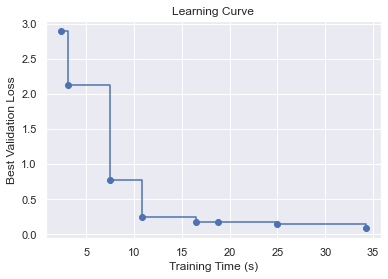

In [5]:
# import warnings
# warnings.filterwarnings('ignore')

# define a learner for the estimator
def my_loss(y_true, y_pred):
    # fair loss
    c = 0.5  # changed the ocnstant here
    residual = y_pred - y_true
    grad_fair = c * residual /(np.abs(residual) + c)
    hess_fair = c ** 2 / (np.abs(residual) + c) ** 2
    
    return grad_fair, hess_fair


class my_lgbm(LGBMEstimator):
    
    def __init__(self, categorical_feature='auto', feature_name='auto', **params):  # LGBM recognize categorical features automatically
        super().__init__( objective=my_loss, **params)  # add customized learned to the estimator
        
        if "min_child_samples" in self.params:
            self.params["min_child_samples"] = None  # set as None to remove the param from the estimator
        
    @classmethod
    def search_space(cls, data_size, **params):
        upper = min(32768, int(data_size))
        return {
            'n_estimators': {'domain': tune.lograndint(lower=40, upper=upper), 'init_value': 100, 'low_cost_init_value': 100},
            'num_leaves': {'domain': tune.lograndint(lower=4, upper=upper), 'init_value': 4, 'low_cost_init_value': 4},
            'min_child_samples': {'domain': tune.lograndint(lower=2, upper=2**7), 'init_value': 20},  # ignored param but has to appear here
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0), 'init_value': 0.1},
            'subsample': {'domain': tune.uniform(lower=0.1, upper=1.0), 'init_value': 1.0},
            'log_max_bin': {'domain': tune.lograndint(lower=3, upper=10), 'init_value': 8},
            'colsample_bytree': {'domain': tune.uniform(lower=0.01, upper=1.0), 'init_value': 1.0},
            'reg_alpha': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1 / 1024},
            'reg_lambda': {'domain': tune.loguniform(lower=1 / 1024, upper=1024), 'init_value': 1.0},
            'max_depth': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 7, 'low_cost_init_value': 7},
            'min_data_in_leaf': {'domain': tune.lograndint(lower=2, upper=upper), 'init_value': 50, 'low_cost_init_value': 50},
            'extra_trees': {'domain': True, 'init_value': True, 'low_cost_init_value': True},
        }


automl_sales = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2', 
    "task": 'regression',  # multiclass classification
    "n_splits": 10,
    "estimator_list": ['my_lgbm'],
    "verbose": 0,
    "log_file_name": 'logs/automl_customized_learner_sales.log',  # flaml log file
}

automl_sales.add_learner(learner_name='my_lgbm', learner_class=my_lgbm)
automl_sales.fit(X_train=X_train, y_train=y_train, **settings)


print('Selected Estimator:', automl_sales.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl_sales.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_sales.best_config_train_time))
print()

y_pred = automl_sales.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Testing R2 is {r2}')

# save the optimized automl_sales object
with open('trained_models/automl_customized_learner_sales.pkl', 'wb') as f:
    pickle.dump(automl_sales, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)